# Feature Importance

In this file I use following methods to find out important features in data.

1. Perturbation : Adding noise in the feature checking how the model performance is deteriorated
2. Missing Values : Replacing feature values with 0 and checking how the model performance is deteriorated
3. Permutation : Shuffling the feature values and checking how the model performance is deteriorated
4. Shap Feature Importance: Using Shap's DeepExplainer to see time-step wise feature importance


### Importing Required Libraries and Data

In [87]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
os.chdir("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
tf.compat.v1.keras.backend.get_session
tf.compat.v1.disable_v2_behavior()

#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks

In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data(drop_cols=False)
df_train.shape, df_test.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [7]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-1.0,-1.0,-0.632530,-0.186396,-0.380486,-1.0,...,-0.600784,-0.272028,-1.0,-0.333333,-1.0,-1.0,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-1.0,-1.0,-0.433735,-0.093961,-0.294733,-1.0,...,-0.674373,-0.177376,-1.0,-0.333333,-1.0,-1.0,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-1.0,-1.0,-0.313253,-0.260955,-0.258947,-1.0,...,-0.656414,-0.285110,-1.0,-0.666667,-1.0,-1.0,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-1.0,-1.0,-0.313253,-0.487683,-0.337610,-1.0,...,-0.650222,-0.666795,-1.0,-0.333333,-1.0,-1.0,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-1.0,-1.0,-0.301205,-0.485066,-0.190749,-1.0,...,-0.650532,-0.195845,-1.0,-0.166667,-1.0,-1.0,0.178295,0.409003,187,0


In [8]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,-1.0,-1.0,0.090361,-0.378679,-0.461175,-1.0,...,0.292111,-0.558824,-0.735680,-0.382070,-1.0,-0.333333,-1.0,-1.0,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-1.0,-1.0,-0.698795,-0.240898,-0.555368,-1.0,...,0.479744,-0.470588,-0.590463,-0.573682,-1.0,-0.166667,-1.0,-1.0,0.364341,0.373654
2,1,3,0.034483,0.166667,-1.0,-1.0,-0.246988,-0.306736,-0.355503,-1.0,...,0.398721,-0.558824,-0.688719,-0.082724,-1.0,-0.166667,-1.0,-1.0,0.457364,0.442695
3,1,4,0.482759,0.000000,-1.0,-1.0,-0.259036,-0.429693,-0.183997,-1.0,...,0.147122,-0.500000,-0.659820,-0.485956,-1.0,-0.500000,-1.0,-1.0,0.333333,0.324220
4,1,5,0.160920,0.000000,-1.0,-1.0,-0.216867,-0.295836,-0.335922,-1.0,...,0.475480,-0.558824,-0.694499,-0.398230,-1.0,-0.666667,-1.0,-1.0,0.317829,0.432753


In [9]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,0
3,82,3,0
4,91,4,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [10]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [11]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [12]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df], ignore_index=True)    
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [13]:
sequence_length = 50 #predicting using last 30 cycle values
mask_value = 0


Let's prepare data using above functions.

In [14]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 24)


In [15]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [33]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 24)


In [16]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [17]:
nb_features = x_train.shape[2]
nb_out = 1

In [18]:
nb_features

24

In [20]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1

cls_wt = {0: class_1/total, 1: class_0/total}

In [21]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

## Model 1

In [62]:
history = History()
model = Sequential()
model.add(LSTM(units=8, return_sequences=False,
               input_shape=(sequence_length, nb_features)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 1056      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 1,065
Trainable params: 1,065
Non-trainable params: 0
_________________________________________________________________


In [63]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/100


2022-10-02 20:50:43.545807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-02 20:50:43.545828: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-02 20:50:43.555494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-02 20:50:43.569946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-02 20:50:43.672581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-02 20:50:43.67

14157/14157 [==============================] - ETA: 0s - loss: 0.1648 - acc: 0.8575

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2022-10-02 20:51:14.823655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14157/14157 [==============================] - 33s 2ms/sample - loss: 0.1648 - acc: 0.8575 - val_loss: 0.1245 - val_acc: 0.8869
Epoch 2/100
14157/14157 [==============================] - 32s 2ms/sample - loss: 0.1052 - acc: 0.9082 - val_loss: 0.0967 - val_acc: 0.9022
Epoch 3/100
14157/14157 [==============================] - 32s 2ms/sample - loss: 0.0913 - acc: 0.9195 - val_loss: 0.0899 - val_acc: 0.9028
Epoch 4/100
14157/14157 [==============================] - 32s 2ms/sample - loss: 0.0820 - acc: 0.9282 - val_loss: 0.0847 - val_acc: 0.9022
Epoch 5/100
14157/14157 [==============================] - 32s 2ms/sample - loss: 0.0709 - acc: 0.9383 - val_loss: 0.0601 - val_acc: 0.9403
Epoch 6/100
14157/14157 [==============================] - 32s 2ms/sample - loss: 0.0653 - acc: 0.9413 - val_loss: 0.0625 - val_acc: 0.9485
Epoch 7/100
14157/14157 [==============================] - 32s 2ms/sample - loss: 0.0584 - acc: 0.9480 - val_loss: 0.0635 - val_acc: 0.9295
Epoch 8/100
14157/14157 [=======

Text(0.5, 1.0, 'Loss')

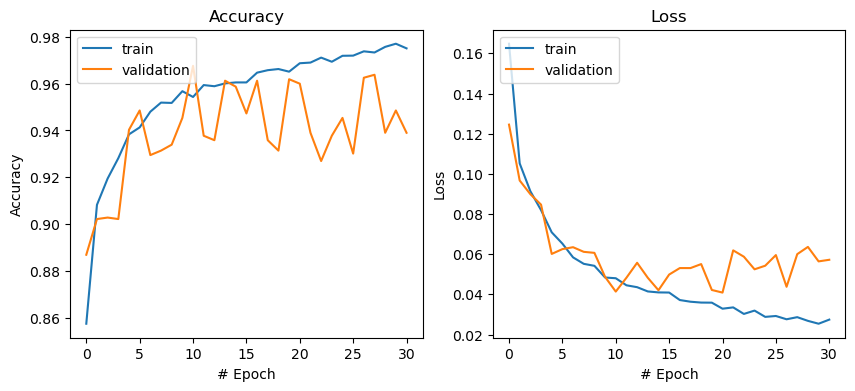

In [65]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

In [66]:
def print_results(y_test, y_pred):    
    #f1-score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_true.failure, y_pred))    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, y_pred) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

2022-10-02 21:44:03.103276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


F1 Score:  0.923076923076923
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        70
           1       0.86      1.00      0.92        30

    accuracy                           0.95       100
   macro avg       0.93      0.96      0.94       100
weighted avg       0.96      0.95      0.95       100

Area under curve :  0.9642857142857143 



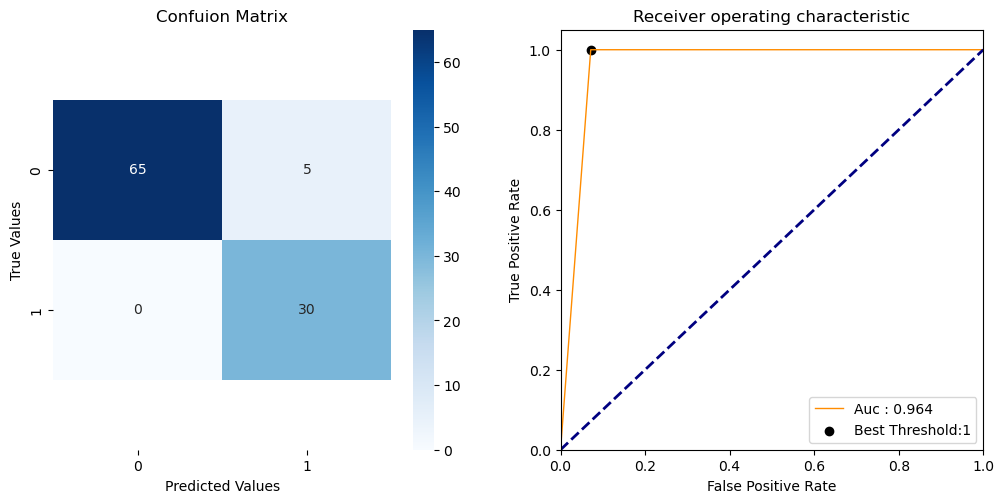

In [67]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")

print_results(y_true.failure, y_pred)

In [68]:
confusion_matrix(y_train, (model.predict(x_train) > 0.5).astype("int32"))

array([[10403,   328],
       [   77,  4923]])

In [69]:
train_probs = model.predict(x_train)

### Perturbation 

In [70]:
y_true['failure_probability'] = model.predict(x_test)
y_true.head()

,RUL,UnitNumber,failure,failure_probability
0,112,0,0,0.000250
1,98,1,0,0.000825
2,69,2,0,0.975032
3,82,3,0,0.021232
4,91,4,0,0.004726


In [71]:
temp= []
for i, feat in enumerate(feats):  
    new_x = x_test.copy()    
    np.random.seed(42)
    perturbation = np.random.normal(0.0, 1, size = new_x.shape[:2])
    new_x[:, :, i] = new_x[:, :, i] + perturbation
    perturbed_out = model.predict(new_x)    
    effect = mean_squared_error(y_true.failure_probability, perturbed_out)
    temp.append({"feature" : feat, "Importance" : effect})
feature_importance = pd.DataFrame(temp)

<AxesSubplot:ylabel='feature'>

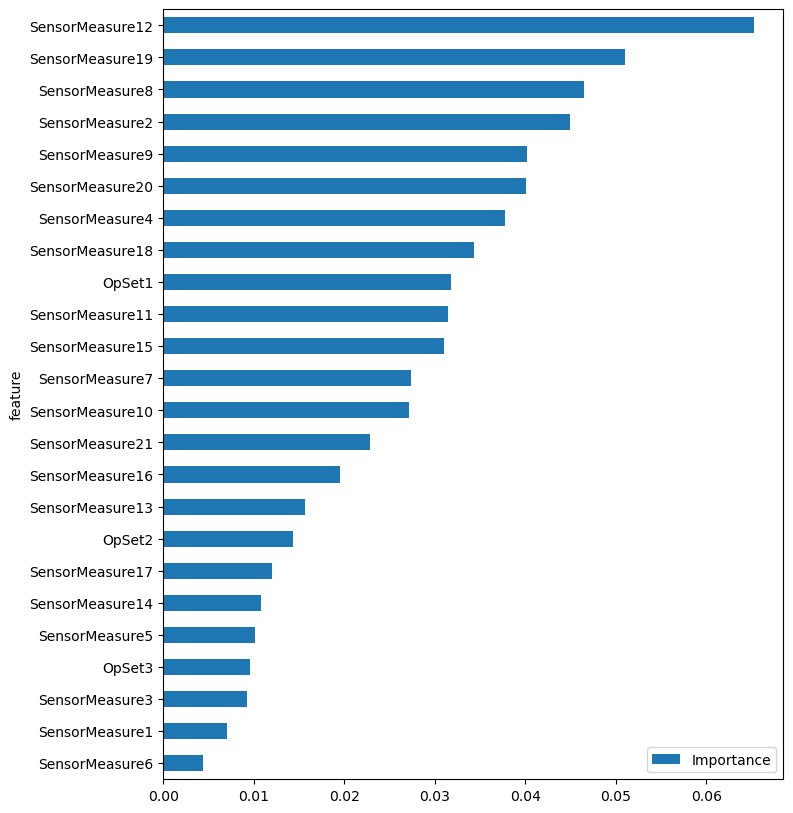

In [72]:
fig, ax = plt.subplots(figsize = (8,10))
feature_importance = feature_importance.sort_values(by = "Importance")
feature_importance.plot.barh(x = 'feature', y = 'Importance', ax = ax)

This is not right because OpSet3 is having on of the highest importance. Since we have only 8 nodes in hidden layer, network is not sparse and the weight of different features are shared. 

To remedy this, I would make sparse network with nodes in a hidden layer more than input features. This also helps for feature learning and to enrich feature represenatation.

## Model 2

In [73]:
len(feats)

24

In [74]:
history = History()
model2 = Sequential()
model2.add(LSTM(
         units=50,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                15000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 15,051
Trainable params: 15,051
Non-trainable params: 0
_________________________________________________________________


In [75]:
%%time
# fit the model
model2.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/100


2022-10-02 21:46:40.132880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-02 21:46:40.175879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-02 21:46:40.209163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-02 21:46:40.218977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14157/14157 [==============================] - ETA: 0s - loss: 0.0943 - acc: 0.9138

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2022-10-02 21:47:11.492484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14157/14157 [==============================] - 33s 2ms/sample - loss: 0.0943 - acc: 0.9138 - val_loss: 0.0610 - val_acc: 0.9339
Epoch 2/100
14157/14157 [==============================] - 32s 2ms/sample - loss: 0.0565 - acc: 0.9486 - val_loss: 0.0688 - val_acc: 0.9422
Epoch 3/100
14157/14157 [==============================] - 32s 2ms/sample - loss: 0.0519 - acc: 0.9501 - val_loss: 0.0512 - val_acc: 0.9396
Epoch 4/100
14157/14157 [==============================] - 32s 2ms/sample - loss: 0.0454 - acc: 0.9560 - val_loss: 0.0643 - val_acc: 0.9269
Epoch 5/100
14157/14157 [==============================] - 32s 2ms/sample - loss: 0.0453 - acc: 0.9571 - val_loss: 0.0768 - val_acc: 0.9155
Epoch 6/100
14157/14157 [==============================] - 33s 2ms/sample - loss: 0.0426 - acc: 0.9597 - val_loss: 0.0554 - val_acc: 0.9524
Epoch 7/100
14157/14157 [==============================] - 33s 2ms/sample - loss: 0.0416 - acc: 0.9593 - val_loss: 0.0625 - val_acc: 0.9396
Epoch 8/100
14157/14157 [=======

Text(0.5, 1.0, 'Loss')

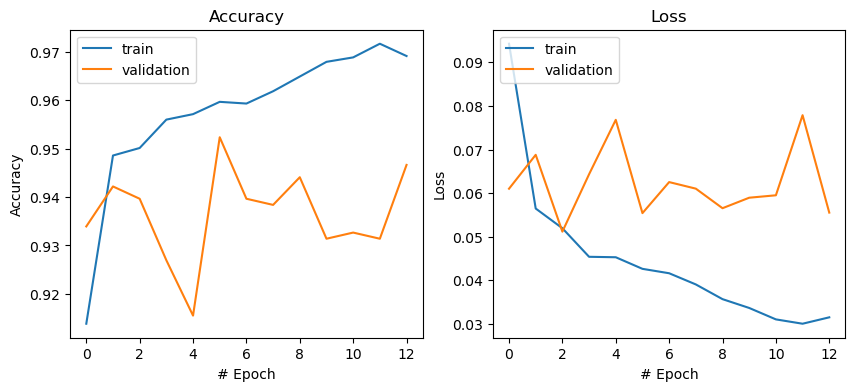

In [76]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

2022-10-02 21:55:21.429249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


F1 Score:  0.967741935483871
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        70
           1       0.94      1.00      0.97        30

    accuracy                           0.98       100
   macro avg       0.97      0.99      0.98       100
weighted avg       0.98      0.98      0.98       100

Area under curve :  0.9857142857142857 



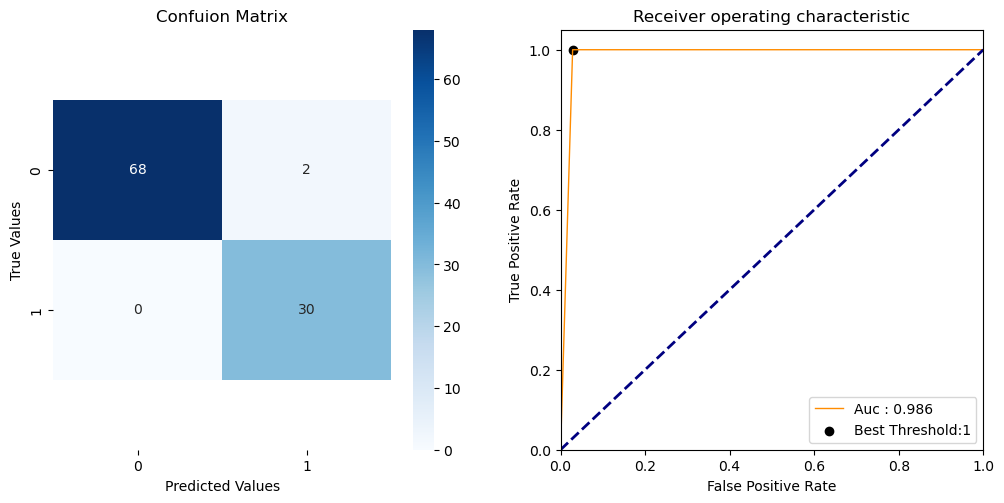

In [77]:
y_pred = (model2.predict(x_test) > 0.5).astype("int32")

print_results(y_true.failure, y_pred)

In [78]:
confusion_matrix(y_train, (model2.predict(x_train) > 0.5).astype("int32"))

array([[10415,   316],
       [  101,  4899]])

In [79]:
test_probs2 = model2.predict(x_test)

### Perturbation 

In [80]:
temp2 = []
for i, feat in enumerate(feats):    
    new_x = x_test.copy()    
    np.random.seed(42)
    perturbation = np.random.normal(0.0, 1, size = new_x.shape[:2])
    new_x[:, :, i] = new_x[:, :, i] + perturbation
    perturbed_out = model2.predict(new_x)    
    effect = mean_squared_error(test_probs2, perturbed_out)
    temp2.append({"feature" : feat, "Importance" : effect})
feature_importance2 = pd.DataFrame(temp2)

Text(0.5, 1.0, 'Perturbation: Feature Importance')

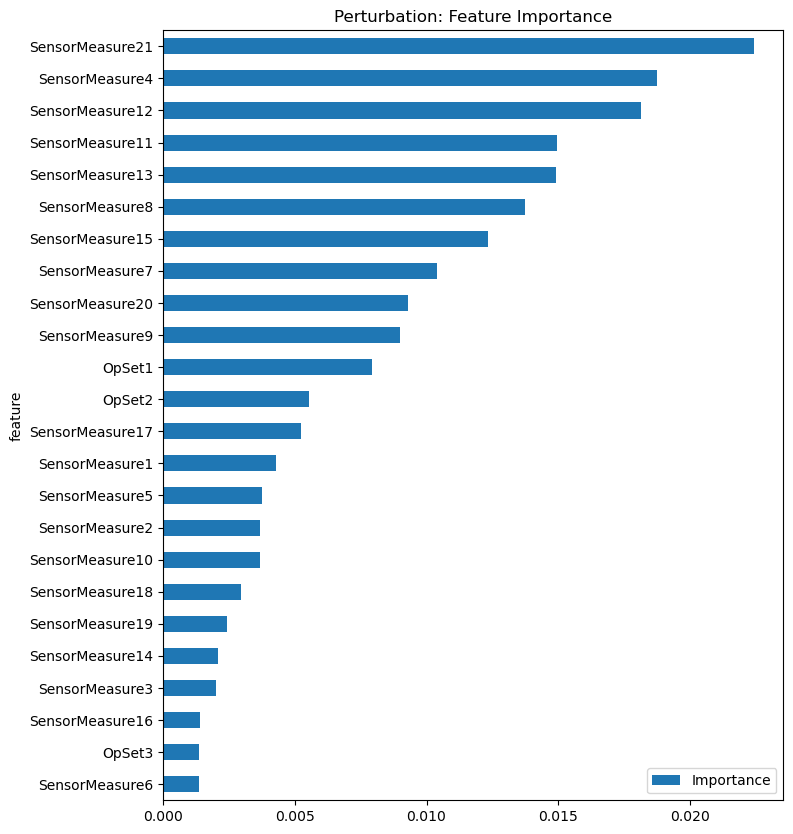

In [81]:
fig, ax = plt.subplots(figsize = (8,10))
feature_importance2 = feature_importance2.sort_values(by = "Importance")
feature_importance2.plot.barh(x = 'feature', y = 'Importance', ax = ax)
ax.set_title('Perturbation: Feature Importance')

### Missing Values 

In [82]:
temp2a = []
for i, feat in enumerate(feats):    
    new_x = x_test.copy()    
    new_x[:, :, i] = 0
    missing_probs = model2.predict(new_x)    
    effect = mean_squared_error(test_probs2, missing_probs)
    temp2a.append({"feature" : feat, "Importance" : effect})
feature_importance2 = pd.DataFrame(temp2a)

Text(0.5, 1.0, 'Missing Values: Feature Importance')

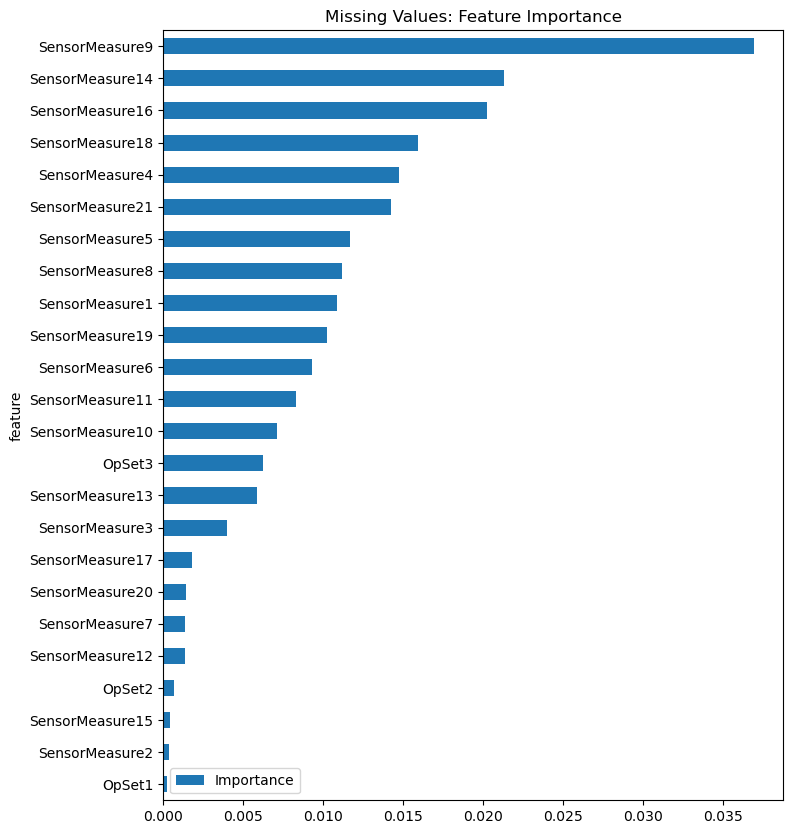

In [83]:
fig, ax = plt.subplots(figsize = (8,10))
feature_importance2 = feature_importance2.sort_values(by = "Importance")
feature_importance2.plot.barh(x = 'feature', y = 'Importance', ax = ax)
ax.set_title('Missing Values: Feature Importance')

### Permutation 

In [84]:
temp2b = []
for i, feat in enumerate(feats):    
    new_x = x_test.copy()    
    np.random.shuffle(new_x[:, :, i])
    permute_probs = model2.predict(new_x)    
    effect = mean_squared_error(test_probs2, permute_probs)
    temp2b.append({"feature" : feat, "Importance" : effect})
feature_importance2 = pd.DataFrame(temp2b)

Text(0.5, 1.0, 'Permutation: Feature Importance')

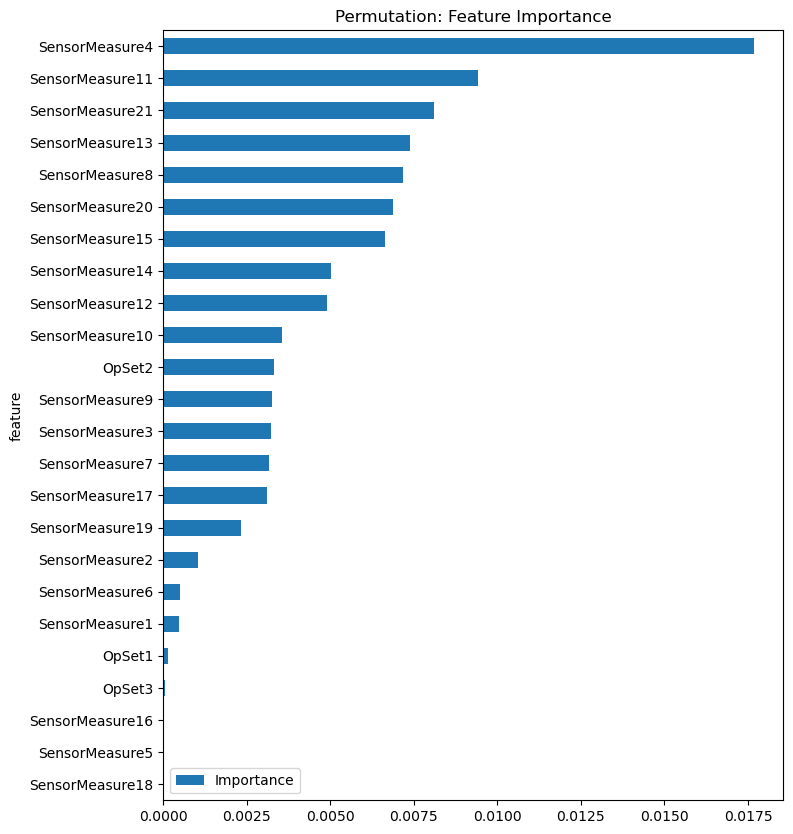

In [85]:
fig, ax = plt.subplots(figsize = (8,10))
feature_importance2 = feature_importance2.sort_values(by = "Importance")
feature_importance2.plot.barh(x = 'feature', y = 'Importance', ax = ax)
ax.set_title('Permutation: Feature Importance')

### Shap Values 

In [86]:
import shap
random_ind = np.random.choice(x_train.shape[0], 1000, replace = False)
data = x_train[random_ind[0:1000]]
DE = shap.DeepExplainer(model2, data)
shap_val = DE.shap_values(x_test)
shap_val = np.array(shap_val)
shap_val = np.reshape(shap_val, (shap_val.shape[1], shap_val.shape[2], shap_val.shape[3]))
shap_abs = np.abs(shap_val)
sum_0 = np.sum(shap_abs, axis = 0)
print(sum_0.shape)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


2022-10-02 21:57:32.342553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-02 21:57:32.647920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(50, 24)


#### Last day's important features

Text(0.5, 1.0, 'Shap Feature Importance of last cycle')

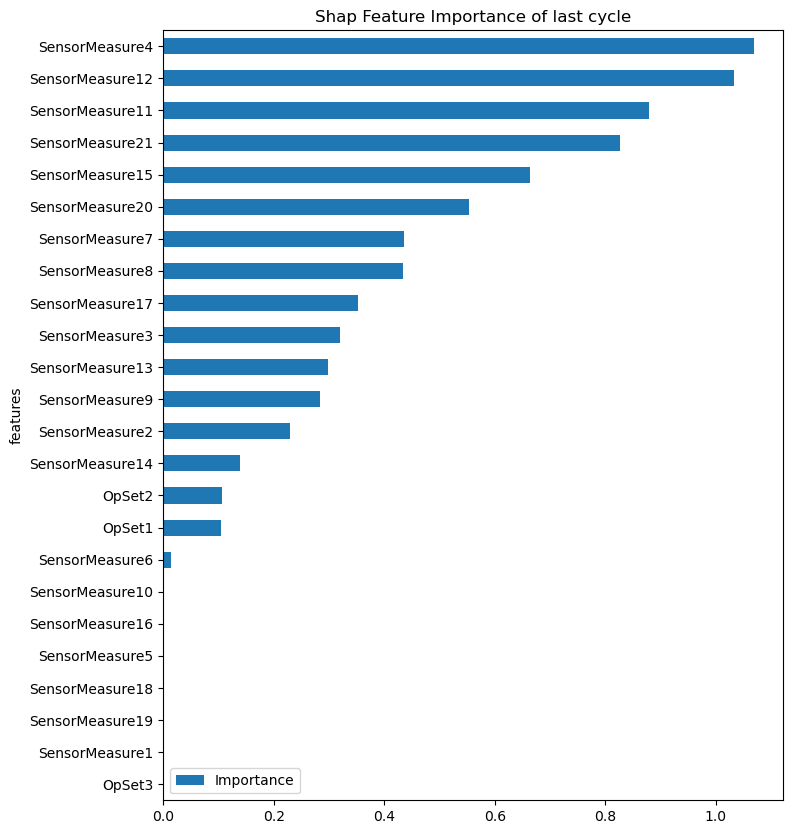

In [88]:
shap_feat_importance = pd.DataFrame(columns=["features", "Importance"])
shap_feat_importance.features = feats
shap_feat_importance.Importance = sum_0[49]

fig, ax = plt.subplots(figsize = (8,10))
shap_feat_importance = shap_feat_importance.sort_values(by = "Importance")
shap_feat_importance.plot.barh(x = 'features', y = 'Importance', ax = ax)
ax.set_title('Shap Feature Importance of last cycle')

#### First day's important features

Text(0.5, 1.0, 'Shap Feature Importance of first cycle')

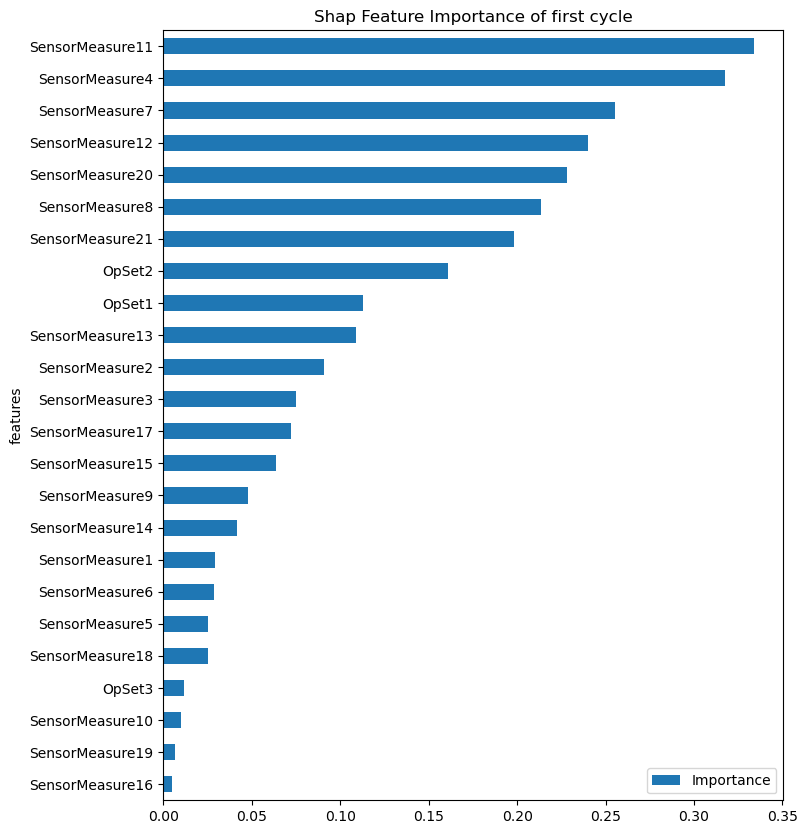

In [89]:
shap_feat_importance = pd.DataFrame(columns=["features", "Importance"])
shap_feat_importance.features = feats
shap_feat_importance.Importance = sum_0[0]

fig, ax = plt.subplots(figsize = (8,10))
shap_feat_importance = shap_feat_importance.sort_values(by = "Importance")
shap_feat_importance.plot.barh(x = 'features', y = 'Importance', ax = ax)
ax.set_title('Shap Feature Importance of first cycle')

#### Over all feature importance

Text(0.5, 1.0, 'Shap Feature Importance')

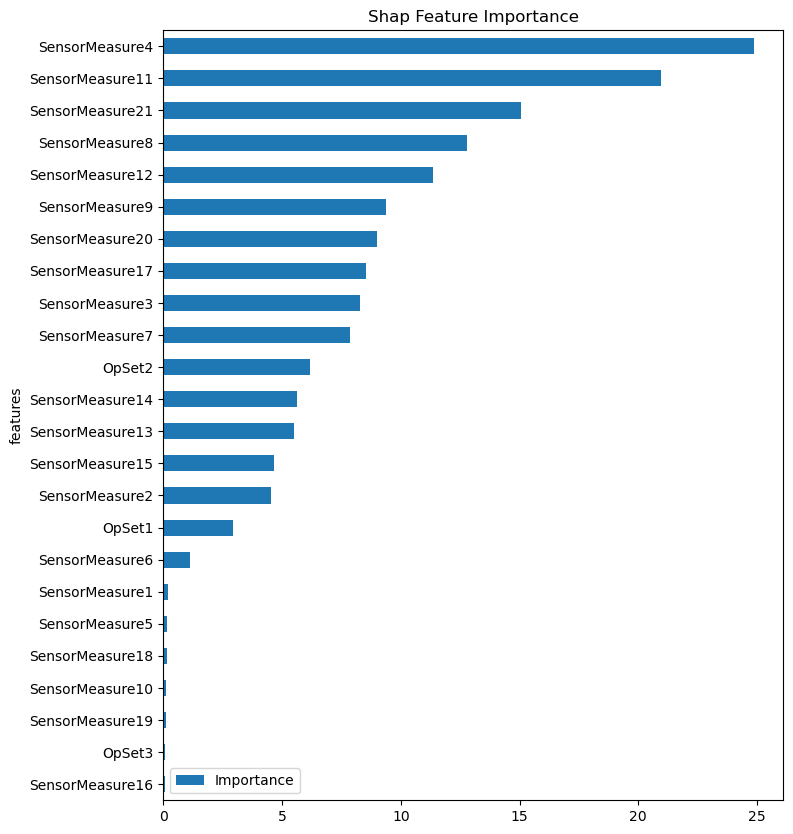

In [90]:
shap_feat_importance = pd.DataFrame(columns=["features", "Importance"])
shap_feat_importance.features = feats
shap_feat_importance.Importance = sum_0.sum(axis = 0)

fig, ax = plt.subplots(figsize = (8,10))
shap_feat_importance = shap_feat_importance.sort_values(by = "Importance")
shap_feat_importance.plot.barh(x = 'features', y = 'Importance', ax = ax)
ax.set_title('Shap Feature Importance')

### Feature Importance Visualization over time steps

In [91]:
feat_imp_df = pd.DataFrame(sum_0, columns=feats)
feat_imp_df.head()

,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,0.113066,0.160708,0.011882,0.029171,0.091004,0.075051,0.317298,0.025401,0.028395,0.255318,...,0.239913,0.108864,0.041883,0.063886,0.004665,0.072182,0.025331,0.006766,0.228040,0.198429
1,0.106206,0.082459,0.008408,0.019168,0.100611,0.066174,0.212963,0.016784,0.017361,0.205870,...,0.228220,0.103947,0.053518,0.041550,0.004353,0.089138,0.018370,0.005421,0.158808,0.151613
2,0.070837,0.054372,0.005857,0.012595,0.092359,0.066710,0.187804,0.012171,0.009489,0.217721,...,0.184864,0.086302,0.061734,0.032543,0.003946,0.086331,0.011179,0.004640,0.139385,0.094651
3,0.049933,0.072419,0.004769,0.012152,0.101037,0.071851,0.171528,0.011958,0.011490,0.148277,...,0.158516,0.074306,0.074813,0.025315,0.004563,0.124379,0.008055,0.006312,0.083395,0.081939
4,0.035603,0.095255,0.003883,0.005355,0.095830,0.084812,0.140507,0.005345,0.009211,0.143880,...,0.116040,0.073704,0.082611,0.027998,0.000928,0.126934,0.006346,0.002465,0.074866,0.083588


#### Operational Setting

Text(0, 0.5, 'Feature Importance')

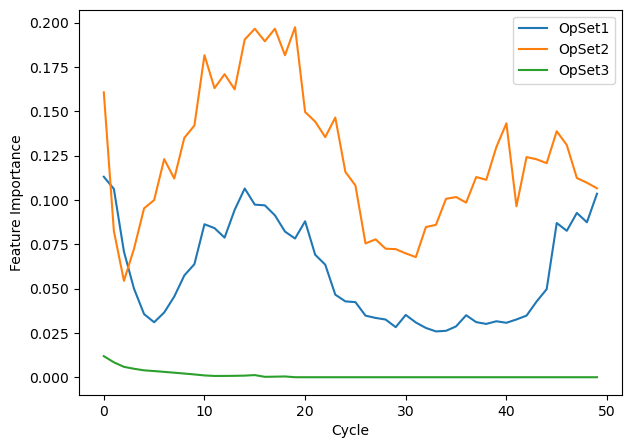

In [92]:
fig, ax = plt.subplots(figsize = (7,5))
feat_imp_df[["OpSet1", "OpSet2", "OpSet3"]].plot(ax = ax)
ax.set_xlabel("Cycle")
ax.set_ylabel("Feature Importance")

#### Top 5 Sensor Measures

Text(0, 0.5, 'Feature Importance')

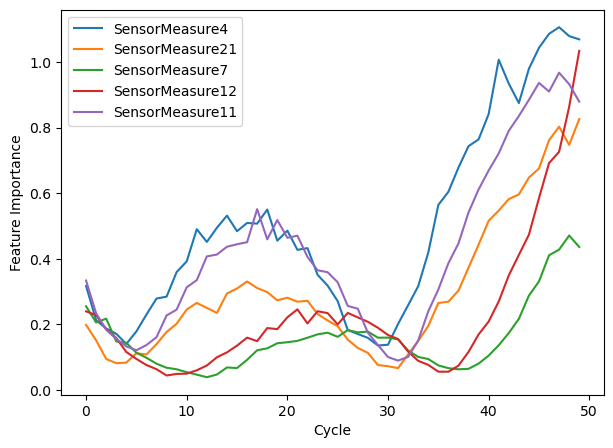

In [93]:
fig, ax = plt.subplots(figsize = (7,5))
feat_imp_df[["SensorMeasure4", "SensorMeasure21", "SensorMeasure7", "SensorMeasure12", "SensorMeasure11"]].plot(ax = ax)
ax.set_xlabel("Cycle")
ax.set_ylabel("Feature Importance")